In [1]:
import gc
from itertools import combinations
import pathlib
from typing import Dict, List
import warnings
import yaml

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import polars as pl
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

gc.enable()
pd.set_option('display.max_columns', 200)
warnings.simplefilter('ignore')

/home/ss/miniconda3/envs/optiver/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def preprocess(df: pd.DataFrame):
    df = pl.from_pandas(df)
    new_features1 = [
        (pl.col('date_id') % 5).alias('day_of_week'),
        (pl.col('imbalance_buy_sell_flag') + 1).alias('imbalance_buy_sell_flag'),
        (pl.col('ask_price') - pl.col('bid_price')).alias('diff_ask_price_bid_price'),
        (pl.col('ask_price') - pl.col('reference_price')).alias('diff_ask_price_reference_price'),
        (pl.col('bid_price') - pl.col('reference_price')).alias('diff_bid_price_reference_price'),
        (pl.col('ask_price') - pl.col('wap')).alias('diff_ask_price_wap'),
        (pl.col('bid_price') - pl.col('wap')).alias('diff_bid_price_wap'),
        (pl.col('far_price') - pl.col('near_price')).alias('diff_far_price_near_price'),
        (pl.col('far_price') - pl.col('reference_price')).alias('diff_far_price_reference_price'),
        (pl.col('near_price') - pl.col('reference_price')).alias('diff_near_price_reference_price'),
        (pl.col('ask_size') - pl.col('bid_size')).alias('diff_ask_size_bid_size'),
        (pl.col('ask_size') - pl.col('matched_size')).alias('diff_ask_size_matched_size'),
        (pl.col('bid_size') - pl.col('matched_size')).alias('diff_bid_size_matched_size'),
        (pl.col('imbalance_size') - pl.col('matched_size')).alias('diff_imbalance_size_matched_size'),
        (pl.col('ask_price') + pl.col('bid_price')).alias('sum_ask_price_bid_price'),
        (pl.col('far_price') + pl.col('near_price')).alias('sum_far_price_near_price'),
        (pl.col('ask_size') + pl.col('bid_size')).alias('sum_ask_size_bid_size'),
        (pl.col('bid_size') * pl.col('ask_price') / (pl.col('bid_size') + pl.col('ask_size'))).alias('wap_factor1'),
        (pl.col('ask_size') * pl.col('bid_price') / (pl.col('bid_size') + pl.col('ask_size'))).alias('wap_factor2'),
        (pl.col('near_price') / pl.col('far_price')).alias('div_near_price_far_price'),

        ((pl.col('ask_price') - pl.col('bid_price')) / (pl.col('reference_price') - pl.col('bid_price'))).alias('feature1'), 
        ((pl.col('ask_price') - pl.col('bid_price')) / (pl.col('wap') - pl.col('bid_price'))).alias('feature2'), 
        ((pl.col('ask_price') - pl.col('reference_price')) / (pl.col('bid_price') - pl.col('reference_price'))).alias('feature3'), 
        ((pl.col('ask_price') - pl.col('reference_price')) / (pl.col('wap') - pl.col('reference_price'))).alias('feature4'), 
        ((pl.col('ask_price') - pl.col('wap')) / (pl.col('bid_price') - pl.col('wap'))).alias('feature5'), 
        ((pl.col('ask_price') - pl.col('wap')) / (pl.col('reference_price') - pl.col('wap'))).alias('feature6'),
        ((pl.col('bid_price') - pl.col('ask_price')) / (pl.col('reference_price') - pl.col('ask_price'))).alias('feature7'),
        ((pl.col('bid_price') - pl.col('ask_price')) / (pl.col('wap') - pl.col('ask_price'))).alias('feature8'),
        ((pl.col('bid_price') - pl.col('reference_price')) / (pl.col('wap') - pl.col('reference_price'))).alias('feature9'),
        ((pl.col('bid_price') - pl.col('wap')) / (pl.col('reference_price') - pl.col('wap'))).alias('feature10'),
        ((pl.col('reference_price') - pl.col('ask_price')) / (pl.col('wap') - pl.col('ask_price'))).alias('feature11'),
        ((pl.col('reference_price') - pl.col('bid_price')) / (pl.col('wap') - pl.col('bid_price'))).alias('feature12'),

        ((pl.col('ask_size') - pl.col('bid_size')) / (pl.col('matched_size') - pl.col('bid_size'))).alias('feature13'), 
        ((pl.col('ask_size') - pl.col('bid_size')) / (pl.col('imbalance_size') - pl.col('bid_size'))).alias('feature14'), 
        ((pl.col('ask_size') - pl.col('matched_size')) / (pl.col('bid_size') - pl.col('imbalance_size'))).alias('feature15'), 
        ((pl.col('ask_size') - pl.col('matched_size')) / (pl.col('imbalance_size') - pl.col('matched_size'))).alias('feature16'), 
        ((pl.col('ask_size') - pl.col('imbalance_size')) / (pl.col('bid_size') - pl.col('imbalance_size'))).alias('feature17'), 
        ((pl.col('ask_size') - pl.col('imbalance_size')) / (pl.col('matched_size') - pl.col('imbalance_size'))).alias('feature18'),
        ((pl.col('bid_size') - pl.col('ask_size')) / (pl.col('matched_size') - pl.col('ask_size'))).alias('feature19'),
        ((pl.col('bid_size') - pl.col('ask_size')) / (pl.col('imbalance_size') - pl.col('ask_size'))).alias('feature20'),
        ((pl.col('bid_size') - pl.col('matched_size')) / (pl.col('imbalance_size') - pl.col('matched_size'))).alias('feature21'),
        ((pl.col('bid_size') - pl.col('imbalance_size')) / (pl.col('matched_size') - pl.col('imbalance_size'))).alias('feature22'),
        ((pl.col('matched_size') - pl.col('ask_size')) / (pl.col('imbalance_size') - pl.col('ask_size'))).alias('feature23'),
        ((pl.col('matched_size') - pl.col('bid_size')) / (pl.col('imbalance_size') - pl.col('bid_size'))).alias('feature24'),

        (pl.col('bid_price') / pl.col('ask_price')).alias('feature25'),
        (pl.col('reference_price') / pl.col('ask_price')).alias('feature26'),
        (pl.col('wap') / pl.col('ask_price')).alias('feature27'),
        (pl.col('reference_price') / pl.col('bid_price')).alias('feature28'),
        (pl.col('wap') / pl.col('bid_price')).alias('feature29'),

        (pl.col('bid_size') / pl.col('ask_size')).alias('feature30'),
        (pl.col('ask_size') / pl.col('matched_size')).alias('feature31'),
        (pl.col('bid_size') / pl.col('matched_size')).alias('feature32'),
        (pl.col('imbalance_size') / pl.col('matched_size')).alias('feature33'),
        (pl.col('ask_size') / pl.col('imbalance_size')).alias('feature34'),
        (pl.col('bid_size') / pl.col('imbalance_size')).alias('feature35'),

        (pl.col('imbalance_size') * (pl.col('ask_price') - pl.col('bid_price'))).alias('feature36'),
        ((pl.col('ask_price') - pl.col('bid_price')) * ((pl.col('ask_size') - pl.col('bid_size')) / (pl.col('ask_size') + pl.col('bid_size')))).alias('feature37'),
    ]

    new_features2 = [
        pl.col('wap').mean().over(['date_id', 'seconds_in_bucket']).alias(f'mean_wap_over_stocks'),
    ]

    lag_features = [
        'ask_price',
        'bid_price',
        'reference_price',
        'wap',
        'far_price',
        'near_price',
        'mean_wap_over_stocks',
        'ask_size',
        'bid_size',
        'matched_size',
        'imbalance_size',
    ]

    new_features3 = [
        pl.col(lag_features).diff(n=1).over(['stock_id']).name.suffix('_diff1'),
        pl.col(lag_features).diff(n=2).over(['stock_id']).name.suffix('_diff2'),
        pl.col(lag_features).diff(n=3).over(['stock_id']).name.suffix('_diff3'),
        pl.col(lag_features).diff(n=4).over(['stock_id']).name.suffix('_diff4'),
        pl.col(lag_features).diff(n=5).over(['stock_id']).name.suffix('_diff5'),
        pl.col(lag_features).diff(n=6).over(['stock_id']).name.suffix('_diff6'),

        # pl.col(lag_features).pct_change(n=1).over(['stock_id']).name.suffix('pct_change1'),
        # pl.col(lag_features).pct_change(n=2).over(['stock_id']).name.suffix('pct_change2'),
        # pl.col(lag_features).pct_change(n=3).over(['stock_id']).name.suffix('pct_change3'),
        # pl.col(lag_features).pct_change(n=4).over(['stock_id']).name.suffix('pct_change4'),
        # pl.col(lag_features).pct_change(n=5).over(['stock_id']).name.suffix('pct_change5'),
        # pl.col(lag_features).pct_change(n=6).over(['stock_id']).name.suffix('pct_change6'),
    ]
    
    transform_features = [
        'imbalance_size',
        'reference_price',
        'matched_size',
        'far_price',
        'near_price',
        'bid_price',
        'bid_size',
        'ask_price',
        'ask_size',
        'wap',
    ]

    new_features4 = [
        ((pl.col(feature) - pl.col(feature).quantile(0.5)) / (pl.col(feature).quantile(0.75) - pl.col(feature).quantile(0.25)))
        .over(['date_id', 'seconds_in_bucket'])
        .alias(f'robust_scaled_{feature}_over_stocks')
        for feature in transform_features
    ]

    df = (
        df
        .with_columns(new_features1)
        .with_columns(new_features2)
        .with_columns(new_features3)
        .with_columns(new_features4)
        .drop(['row_id'])
        .to_pandas()
    )
    return df

In [3]:
inputs_dir_path = pathlib.Path('../inputs')
outputs_dir_path = pathlib.Path('../outputs')
if not outputs_dir_path.is_dir():
    outputs_dir_path.mkdir()

train_df = pd.read_csv(inputs_dir_path. joinpath('train.csv'))
train_df.drop(columns=['time_id'], inplace=True)
train_df = preprocess(train_df)
train_df = train_df.dropna(subset=['target'])
display(train_df)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,day_of_week,diff_ask_price_bid_price,diff_ask_price_reference_price,diff_bid_price_reference_price,diff_ask_price_wap,diff_bid_price_wap,diff_far_price_near_price,diff_far_price_reference_price,diff_near_price_reference_price,diff_ask_size_bid_size,diff_ask_size_matched_size,diff_bid_size_matched_size,diff_imbalance_size_matched_size,sum_ask_price_bid_price,sum_far_price_near_price,sum_ask_size_bid_size,wap_factor1,wap_factor2,div_near_price_far_price,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,feature35,feature36,feature37,mean_wap_over_stocks,ask_price_diff1,bid_price_diff1,reference_price_diff1,wap_diff1,far_price_diff1,near_price_diff1,mean_wap_over_stocks_diff1,ask_size_diff1,bid_size_diff1,matched_size_diff1,imbalance_size_diff1,ask_price_diff2,bid_price_diff2,reference_price_diff2,wap_diff2,far_price_diff2,near_price_diff2,mean_wap_over_stocks_diff2,ask_size_diff2,bid_size_diff2,matched_size_diff2,imbalance_size_diff2,ask_price_diff3,bid_price_diff3,reference_price_diff3,wap_diff3,far_price_diff3,near_price_diff3,mean_wap_over_stocks_diff3,ask_size_diff3,bid_size_diff3,matched_size_diff3,imbalance_size_diff3,ask_price_diff4,bid_price_diff4,reference_price_diff4,wap_diff4,far_price_diff4,near_price_diff4,mean_wap_over_stocks_diff4,ask_size_diff4,bid_size_diff4,matched_size_diff4,imbalance_size_diff4,ask_price_diff5,bid_price_diff5,reference_price_diff5,wap_diff5,far_price_diff5,near_price_diff5,mean_wap_over_stocks_diff5,ask_size_diff5,bid_size_diff5,matched_size_diff5,imbalance_size_diff5,ask_price_diff6,bid_price_diff6,reference_price_diff6,wap_diff6,far_price_diff6,near_price_diff6,mean_wap_over_stocks_diff6,ask_size_diff6,bid_size_diff6,matched_size_diff6,imbalance_size_diff6,robust_scaled_imbalance_size_over_stocks,robust_scaled_reference_price_over_stocks,robust_scaled_matched_size_over_stocks,robust_scaled_far_price_over_stocks,robust_scaled_near_price_over_stocks,robust_scaled_bid_price_over_stocks,robust_scaled_bid_size_over_stocks,robust_scaled_ask_price_over_stocks,robust_scaled_ask_size_over_stocks,robust_scaled_wap_over_stocks
0,0,0,0,3180602.69,2,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0.000214,0.000214,0.000000,0.000026,-0.000188,NaN,NaN,NaN,-52158.47,-13371783.61,-13319625.14,-10199673.95,1.999838,NaN,69144.53,0.877193,0.122807,NaN,inf,1.138298,inf,1.138298,-0.138298,-0.138298,1.000000,8.230769,0.000000,1.000000,8.230769,0.000000,-0.003916,-0.016718,4.285895,1.311001,1.016718,-0.311001,0.003901,0.016443,1.305887,-0.305887,4.215423,4.269177,0.999786,0.999786,0.999974,1.000000,1.000188,7.141326,0.000635,0.004533,0.237708,0.002670,0.019069,680.648976,-0.000161,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.328788,-0.219344,1.079826,NaN,NaN,0.002415,1.583755,-0.549161,-0.282812,NaN
1,1,0,0,166603.91,0,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0.000764,0.000764,0.000000,0.000660,-0.000104,NaN,NaN,NaN,17372.05,-1621609.16,-1638981.21,-1475610.34,2.000556,NaN,23838.13,0.135714,0.864285,NaN,inf,7.346154,inf,7.346154,-6.346154,-6.346154,1.000000,1.157576,0.000000,1.000000,1.157576,0.000000,0.010599,0.106335,9.925938,1.098941,0.893665,-0.098941,-0.010713,-0.118988,1.110714,-0.110714,11.107002,10.032273,0.999237,0.999237,0.999340,1.000000,1.000104,0.15690

## train lightgbm models using cross validation

In [4]:
def train(
        dataset: pd.DataFrame,
        outputs_dir: pathlib.Path,
    ):
    
    target_columns = ['stock_id', 'date_id', 'seconds_in_bucket', 'target']
    feature_columns = [col for col in dataset.columns if col not in ['date_id', 'target']]
    days= np.arange(dataset['date_id'].min(), dataset['date_id'].max())
    fimps = []
    best_param_records = {}
    best_value_records = {}
    history = {
        'train_mae': [],
        'valid_mae': [],
        'test_mae': [],
    }
    valid_days = days[-60*2:-60]
    test_days = days[-60:]
    valid_X = dataset.query('date_id in @valid_days')[feature_columns]
    valid_y = dataset.query('date_id in @valid_days')[target_columns]
    test_X = dataset.query('date_id in @test_days')[feature_columns]
    test_y = dataset.query('date_id in @test_days')[target_columns]

    train_day_limits = [(300, 360), (240, 360), (180, 360), (120, 360), (60, 360), (0, 360)]

    for k, limits in enumerate(train_day_limits):
        train_days = np.arange(*limits)
        print(f'fold {k+1}')
        print(train_days)
        print(valid_days)
        
        plot_time(days, train_days, valid_days, test_days)
        
        train_X = dataset.query('date_id in @train_days')[feature_columns]
        train_y = dataset.query('date_id in @train_days')[target_columns]
        print(f'train_X.shape: {train_X.shape}, train_y.shape: {train_y.shape}')
        print(f'valid_X.shape: {valid_X.shape}, valid_y.shape: {valid_y.shape}')
        print(f'test_X.shape: {test_X.shape}, test_y.shape: {test_y.shape}')
        
        objective = Objective(train_X, train_y['target'], valid_X, valid_y['target'])
        study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=42))
        optuna.logging.set_verbosity(optuna.logging.WARNING)
        study.optimize(objective, n_trials=5)

        best_params = study.best_params
        add_params = {
            'task': 'train',
            'boosting_type': 'gbdt',
            'objective': 'mae',
            'metric': 'mae',
            'seed': 42,
        }
        best_params.update(add_params)
        
        [print(f'{k}: {v}') for k, v in best_params.items()]
        print(f'best value: {study.best_value}')

        callbacks = [
            lgb.early_stopping(stopping_rounds=100, verbose=True),
            lgb.log_evaluation(100),
        ]
        
        train_dataset = lgb.Dataset(
            train_X,
            train_y['target'],
            #categorical_feature=['imbalance_buy_sell_flag'],
        )

        valid_dataset = lgb.Dataset(
            valid_X,
            valid_y['target'],
            #categorical_feature=['imbalance_buy_sell_flag'],
        )
        
        model = lgb.train(
            params=best_params,
            train_set=train_dataset,
            valid_sets=[train_dataset, valid_dataset],
            valid_names=['train', 'valid'],
            callbacks=callbacks,
            num_boost_round=5000,
        )
        model.save_model(
            outputs_dir.joinpath(f'lightgbm_optuna_fold{k+1}.txt'),
            num_iteration=model.best_iteration
        )
        
        best_params['num_boost_round'] = model.best_iteration
        best_param_records[f'fold{k+1}'] = best_params
        best_value_records[f'fold{k+1}'] = study.best_value

        fimp = model.feature_importance(importance_type='gain')
        fimp = pd.DataFrame(fimp, index=feature_columns, columns=[f'fold{k+1}'])
        fimps.append(fimp)

        train_pred = model.predict(train_X, num_iteration=model.best_iteration)
        valid_pred = model.predict(valid_X, num_iteration=model.best_iteration)
        test_pred = model.predict(test_X, num_iteration=model.best_iteration)

        test_y[f'regression_fold{k+1}'] = test_pred

        history['train_mae'].append(mean_absolute_error(train_y['target'], train_pred))
        history['valid_mae'].append(mean_absolute_error(valid_y['target'], valid_pred))
        history['test_mae'].append(mean_absolute_error(test_y['target'], test_pred))
        
        del objective, study
        del train_X, train_y, train_dataset, valid_dataset, model, fimp
        del train_pred, valid_pred, test_pred
        gc.collect()

    del valid_X, valid_y, test_X
    gc.collect()

    history = pd.DataFrame.from_dict(history)
    
    fimps = pd.concat(fimps, axis=1)
    mean_fimps = fimps.mean(axis=1)
    std_fimps = fimps.std(axis=1)
    fimps['mean_fimps'] = mean_fimps
    fimps['std_fimps'] = std_fimps
    fimps.sort_values(by='mean_fimps', inplace=True)
    
    test_y['regression'] = test_y[[f'regression_fold{k+1}' for k in range(len(train_day_limits))]].mean(axis=1)
    test_y_mae = mean_absolute_error(test_y['target'], test_y['regression'])
    print(f'test_y mae: {test_y_mae:.4f}')
    
    with open(outputs_dir.joinpath('result_lightgbm_optuna.yaml'), 'w') as f:
        yaml.dump(
            {
                'best_param_records': best_param_records,
                'best_value_records': best_value_records,
                'test_y rmse': test_y_mae,
            },
            f,
            default_flow_style=False
        )
    return history, test_y, fimps, best_param_records


class Objective:
    def __init__(self, train_X, train_y, valid_X, valid_y):
        self.train_X = train_X
        self.train_y = train_y
        self.valid_X = valid_X
        self.valid_y = valid_y

    def __call__(self, trial):
        params = {
            'task': 'train',
            'boosting_type': 'gbdt',
            'objective': 'mae',
            'metric': 'mae',
            'learning_rate': trial.suggest_float('learning_rate', 1e-03, 1e-01),
            'seed': 42,
            'max_depth':  trial.suggest_int('max_depth', 3, 15),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
            'feature_fraction': trial.suggest_float('feature_fraction_bynode', 0.4, 1.0),
            'feature_fraction_bynode': trial.suggest_float('feature_fraction_bynode', 0.4, 1.0),
            'lambda_l2': trial.suggest_float('lambda_l2', 0.1, 10),
            #'bagging_fraction': 0.6,
            'verbose': -1,
        }
        
        callbacks = [
            lgb.early_stopping(stopping_rounds=100, verbose=True),
            lgb.log_evaluation(0),
        ]
        
        train_dataset = lgb.Dataset(self.train_X, self.train_y)
        valid_dataset = lgb.Dataset(self.valid_X, self.valid_y)

        model = lgb.train(
            params=params,
            train_set=train_dataset,
            valid_sets=[train_dataset, valid_dataset],
            valid_names=['train', 'valid'],
            callbacks=callbacks,
            num_boost_round=5000,
        )

        preds = model.predict(self.valid_X, num_iteration=model.best_iteration)
        mae = mean_absolute_error(preds, self.valid_y)

        del params, callbacks, train_dataset, valid_dataset, model, preds
        gc.collect()

        return mae
    

def plot_time(all_time, train_time, valid_time, test_time):
    _, ax = plt.subplots()
    ax.barh(y='all', height=0.6, width=len(all_time), left=0, color='tab:blue')
    ax.barh(y='train+valid+test', height=0.6, width=[len(train_time), len(valid_time), len(test_time)],
            left=[train_time.min(), valid_time.min(), test_time.min()], color=['tab:orange', 'tab:green', 'tab:red'])
    xcenter = [len(all_time)//2, train_time.min()+len(train_time)//2,
               valid_time.min()+len(valid_time)//2, test_time.min()+len(test_time)//2]
    ycenter = [0, 1, 1, 1]
    width = [f'all\n{len(all_time)}', f'train\n{len(train_time)}', f'valid\n{len(valid_time)}', f'test\n{len(test_time)}']
    for x, y, w in zip(xcenter, ycenter, width):
        ax.text(x, y, str(w),  ha='center', va='center')
    ax.set_xticks([train_time.min(), valid_time.min(), test_time.min(), len(all_time)])
    ax.grid(axis='x', linestyle='--')
    ax.tick_params(axis='x', labelrotation=45)
    plt.show()

fold 1
[300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317
 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335
 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353
 354 355 356 357 358 359]
[360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377
 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395
 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413
 414 415 416 417 418 419]


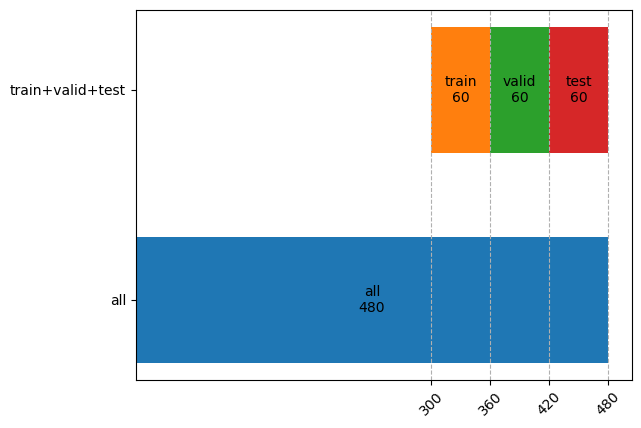

[I 2023-11-22 23:56:56,492] A new study created in memory with name: no-name-4a21feb9-7158-49c5-8c55-65472200b3a9


train_X.shape: (659944, 146), train_y.shape: (659944, 4)
valid_X.shape: (659945, 146), valid_y.shape: (659945, 4)
test_X.shape: (659999, 146), test_y.shape: (659999, 4)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[794]	train's l1: 6.13338	valid's l1: 6.37565
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[3911]	train's l1: 6.24102	valid's l1: 6.379
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[5000]	train's l1: 6.22246	valid's l1: 6.37655
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1189]	train's l1: 6.18199	valid's l1: 6.37481
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[446]	train's l1: 6.24376	valid's l1: 6.37775
learning_rate: 0.01915704647548995
max_depth: 6
min_data_in_leaf: 62
feature_fraction_bynode: 0.659167

KeyboardInterrupt: 

In [5]:
history, result, fimps, best_params_records = train(
    dataset=train_df,
    outputs_dir=outputs_dir_path,
)

In [ ]:
display(result)
print(fimps.shape)
display(fimps.tail(50))

_, ax = plt.subplots(figsize=(12, 18))
fimps['mean_fimps'].plot(kind='barh', xerr=fimps['std_fimps'], capsize=3, ax=ax)  
plt.tight_layout()
plt.show()

fimps_quantile_th = fimps['mean_fimps'].quantile(q=0.2)
display(fimps.query('mean_fimps < @fimps_quantile_th').index)

In [ ]:
history.plot(marker='.', linestyle=':')
plt.show()

In [ ]:
_, ax = plt.subplots()
ax.hist2d(result['regression'], result['target'], bins=100, cmap='Blues', vmax=1e+03)
ax.plot([-100, 100], [-100, 100], color='tab:orange')
ax.set_xlabel('regression')
ax.set_ylabel('target')
plt.show()

r = np.corrcoef(result['regression'], result['target'])
print(f'correlation coeeficient: {r[0, 1]:.4f}')

## train lightgbm model using all data

In [ ]:
best_params = pd.DataFrame(best_params_records)
display(best_params)

new_best_params = {}
for idx in best_params.index:
    if best_params.loc[idx].nunique() > 1:
        new_best_params[idx] = best_params.loc[idx].mean().item()
    else:
        new_best_params[idx] = best_params.loc[idx].unique().item()
    if isinstance(best_params.loc[idx].iloc[0], int):
        new_best_params[idx] = int(new_best_params[idx])

num_boost_round = new_best_params.pop('num_boost_round')
print(new_best_params)

In [ ]:
target_columns = ['stock_id', 'date_id', 'seconds_in_bucket', 'target']
feature_columns = [col for col in train_df.columns if col not in ['date_id', 'target']]

callbacks = [
    lgb.log_evaluation(100),
]

train_dataset = lgb.Dataset(
    train_df[feature_columns],
    train_df[target_columns]['target'],
)

del train_df
gc.collect()

model = lgb.train(
    params=new_best_params,
    train_set=train_dataset,
    callbacks=callbacks,
    num_boost_round=num_boost_round,
)

model.save_model(
    outputs_dir_path.joinpath(f'lightgbm_trained_using_alldata.txt'),
    num_iteration=model.best_iteration
)